On merged dataset

In [ ]:
import os
import shutil

# Define source and destination directories
train_dir = '/kaggle/input/kidney-cancer/data/Training_images'
test_dir = '/kaggle/input/kidney-cancer/data/Test_images'
merged_dir = '/kaggle/working/Merged_images'

# Create the merged directory if it doesn't exist
if not os.path.exists(merged_dir):
    os.makedirs(merged_dir)

# Function to copy images from source to destination
def merge_images(src_dir, dst_dir):
    for grade in os.listdir(src_dir):
        src_grade_dir = os.path.join(src_dir, grade)
        dst_grade_dir = os.path.join(dst_dir, grade)

        if not os.path.exists(dst_grade_dir):
            os.makedirs(dst_grade_dir)

        for img_file in os.listdir(src_grade_dir):
            src_img_path = os.path.join(src_grade_dir, img_file)
            dst_img_path = os.path.join(dst_grade_dir, img_file)

            shutil.copy2(src_img_path, dst_img_path)

# Merge training and testing images into the merged directory
merge_images(train_dir, merged_dir)
merge_images(test_dir, merged_dir)

print("Merging completed.")


Merging completed.


In [ ]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

# Load the dataset with label_mode='categorical' for multi-class labels
data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/Merged_images',
    label_mode='categorical'
)



2024-07-07 19:29:14.138944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 19:29:14.139251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 19:29:14.341470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 237 files belonging to 5 classes.


In [ ]:
# Initialize variables to hold labels
labels_list = []

# Iterate through the dataset to gather labels
for images, labels in data:
    labels_list.extend(np.argmax(labels, axis=1))

# Convert the list of labels to a NumPy array
labels_array = np.array(labels_list)

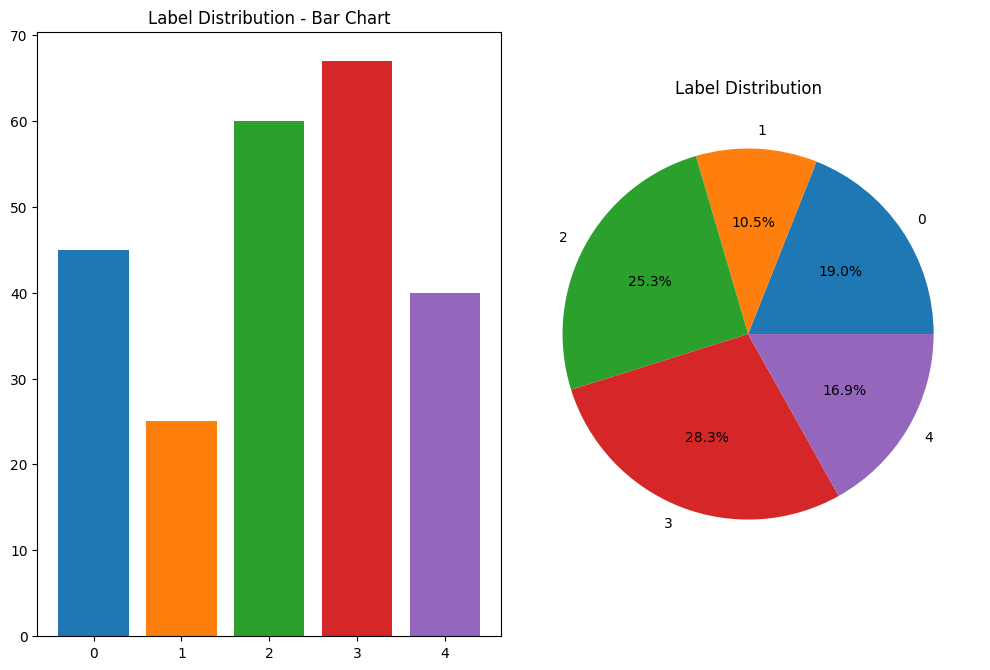

In [ ]:
plt.figure(figsize=(10, 13))

# Bar chart for the label distribution
plt.subplot(2, 2, 1)
unique, counts = np.unique(labels_array, return_counts=True)
plt.bar(unique, counts, color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'])
plt.title('Label Distribution - Bar Chart')

# Pie chart for the label distribution
plt.subplot(2, 2, 2)
plt.pie(counts, labels=unique, autopct='%1.1f%%', colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'])
plt.title('Label Distribution')

plt.tight_layout()
plt.show()

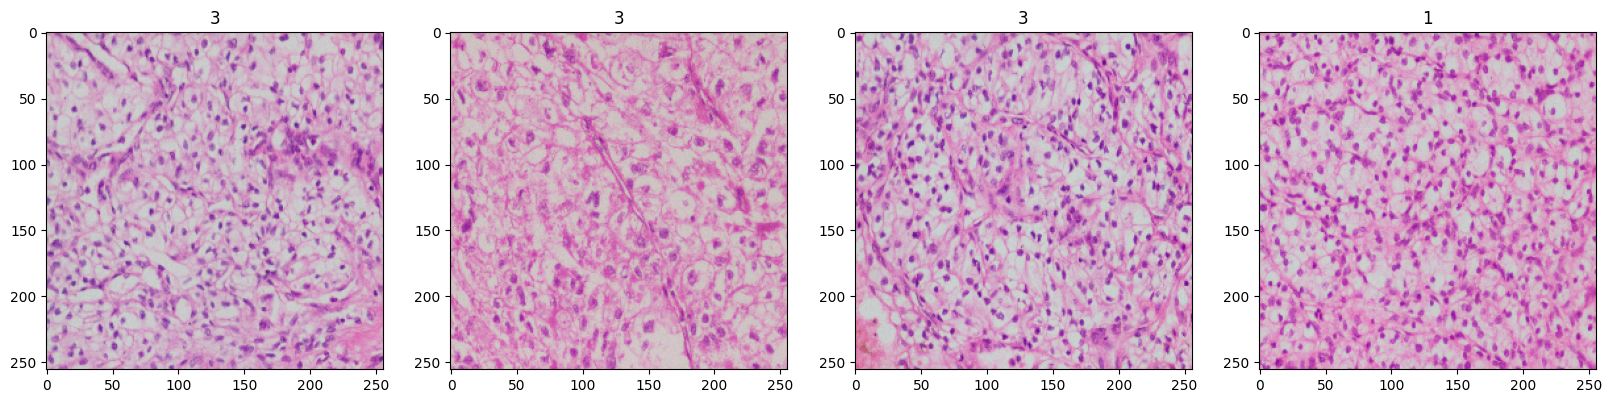

In [ ]:
# Display some sample images and their labels
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(np.argmax(batch[1][idx]))


In [ ]:
# Inspect the first batch before normalization
original_batch = data.as_numpy_iterator().next()[0]
print("Original data range: min =", original_batch.min(), "max =", original_batch.max())


Original data range: min = 0.0 max = 253.90625


In [ ]:
def normalize(x, y):
    x_max = tf.reduce_max(x)
    x_normalized = x / x_max
    return x_normalized, y

data = data.map(normalize)
normalized_batch = data.as_numpy_iterator().next()[0]
print("Normalized data range: min =", normalized_batch.min(), "max =", normalized_batch.max())


Normalized data range: min = 0.0 max = 1.0


In [ ]:
# Splitting the dataset
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.4)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)


Hierarchically Optimized Convolutional Neural Network

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Create a Sequential model
model = Sequential()

# Add convolutional layers with batch normalization and max pooling
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add dropout
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Add dense layers with batch normalization and dropout
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer for multi-class classification
model.add(Dense(5, activation='softmax'))  # Assuming you have 5 classes



In [2]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 flatten (Flatten)           (None, 258064)            0         
                                                                 
 dense (Dense)               (None, 32)                8

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=100, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6385 - loss: 0.8334 - val_accuracy: 0.3125 - val_loss: 6.8195
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7365 - loss: 0.7714 - val_accuracy: 0.1562 - val_loss: 6.7378
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7375 - loss: 0.6892 - val_accuracy: 0.2500 - val_loss: 5.1863
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7802 - loss: 0.6956 - val_accuracy: 0.3229 - val_loss: 4.2717
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8208 - loss: 0.5396 - val_accuracy: 0.3438 - val_loss: 3.5558
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8000 - loss: 0.5382 - val_accuracy: 0.2917 - val_loss: 3.1927
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8667 - loss: 0.4655 - val_accuracy: 0.2500 - val_loss: 3.1203
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8417 - loss: 0.5134 - val_accuracy: 0.1562 - val_loss: 2.8223
Epoch 9

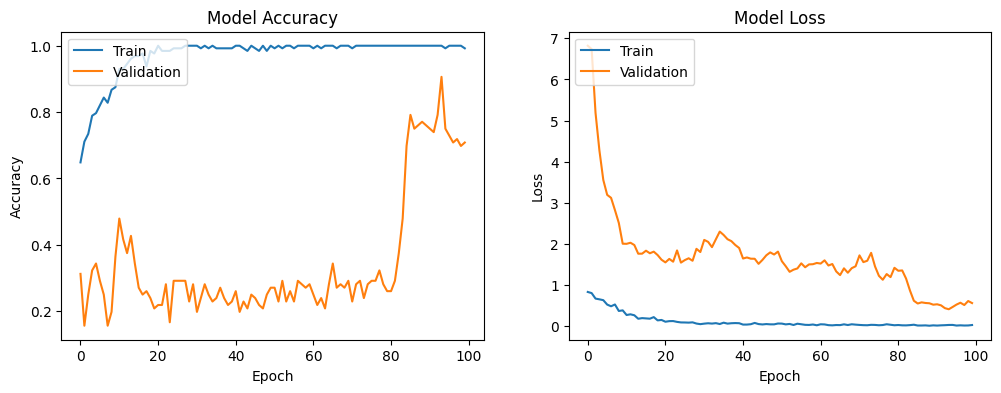

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


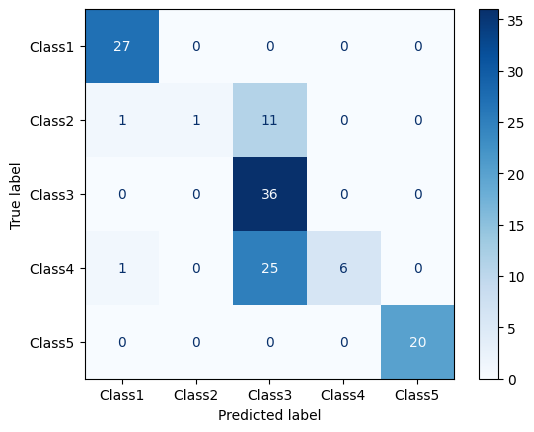

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test data
y_pred = []
y_true = []

for images, labels in train:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Class1', 'Class2', 'Class3', 'Class4', 'Class5'])  # Replace with your class labels
cmd.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test data
y_pred = []
y_true = []

for images, labels in val:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Class1', 'Class2', 'Class3', 'Class4', 'Class5'])  # Replace with your class labels
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
              precision    recall  f1-score   support

      Class1       0.95      1.00      0.98        20
      Class2       0.00      0.00      0.00         8
      Class3       0.49      1.00      0.66        25
      Class4       1.00      0.24      0.39        25
      Class5       1.00      1.00      1.00        18

    accuracy                           0.72        96
   macro avg       0.69      0.65      0.60        96
weighted avg       0.77      0.72      0.66        96



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


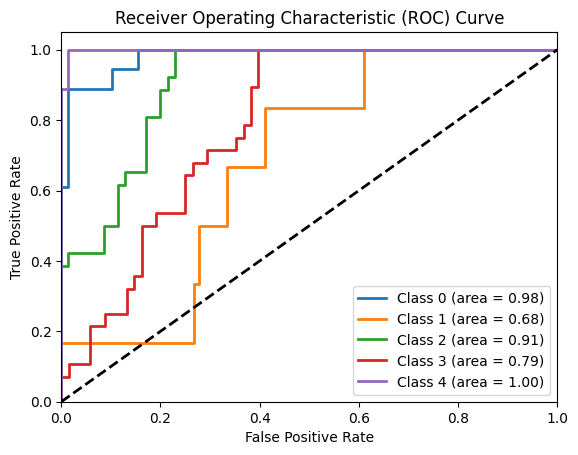

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predict probabilities on the test data
y_pred_prob = []
y_true = []

for images, labels in val:
    predictions = model.predict(images)
    y_pred_prob.extend(predictions)
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Binarize the true labels for ROC calculation
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # Adjust classes to your number of classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], np.array(y_pred_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Base CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a Sequential model
model_no_bn = Sequential()

# Add convolutional layers without batch normalization
model_no_bn.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_no_bn.add(MaxPooling2D(pool_size=(2, 2)))

# Add dropout
model_no_bn.add(Dropout(0.25))

# Flatten the output
model_no_bn.add(Flatten())

# Add dense layers without batch normalization and dropout
model_no_bn.add(Dense(32, activation='relu'))
model_no_bn.add(Dropout(0.5))

# Output layer for multi-class classification
model_no_bn.add(Dense(5, activation='softmax'))

# Compile the model
model_no_bn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_no_bn.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 258064)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     8,258,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,258,693 (31.50 MB)

 Trainable params: 8,258,693 (31.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model_no_bn.fit(train, epochs=70, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2062 - loss: 17.8650 - val_accuracy: 0.1146 - val_loss: 6.5599
Epoch 2/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0792 - loss: 7.0216 - val_accuracy: 0.1146 - val_loss: 1.8908
Epoch 3/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1844 - loss: 1.7325 - val_accuracy: 0.1979 - val_loss: 1.6087
Epoch 4/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2313 - loss: 1.6081 - val_accuracy: 0.3021 - val_loss: 1.6071
Epoch 5/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2667 - loss: 1.6076 - val_accuracy: 0.2917 - val_loss: 1.6073
Epoch 6/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2281 - loss: 1.6072 - val_accuracy: 0.3125 - val_loss: 1.6075
Epoch 7/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2823 - loss: 1.6065 - val_accuracy: 0.2604 - val_loss: 1.6076
Epoch 8/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2865 - loss: 1.6061 - val_accuracy: 0.2708 - val_loss: 1.6060
Epoch 9/70
4/4 

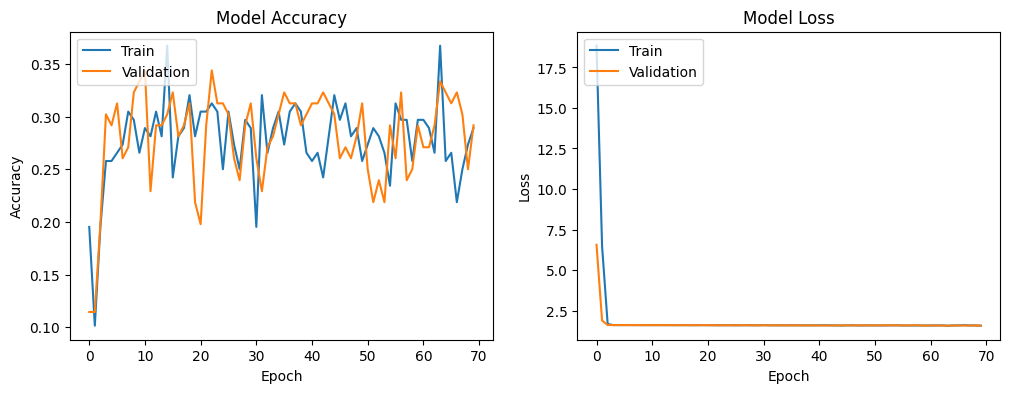

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


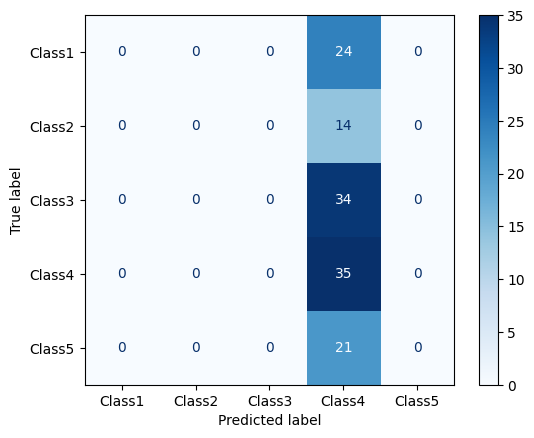

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test data
y_pred = []
y_true = []

for images, labels in train:
    predictions = model_no_bn.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Class1', 'Class2', 'Class3', 'Class4', 'Class5'])  # Replace with your class labels
cmd.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test data
y_pred = []
y_true = []

for images, labels in train:
    predictions = model_no_bn.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Class1', 'Class2', 'Class3', 'Class4', 'Class5'])  # Replace with your class labels
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
              precision    recall  f1-score   support

      Class1       0.00      0.00      0.00        26
      Class2       0.00      0.00      0.00        15
      Class3       0.00      0.00      0.00        25
      Class4       0.30      1.00      0.47        39
      Class5       0.00      0.00      0.00        23

    accuracy                           0.30       128
   macro avg       0.06      0.20      0.09       128
weighted avg       0.09      0.30      0.14       128



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


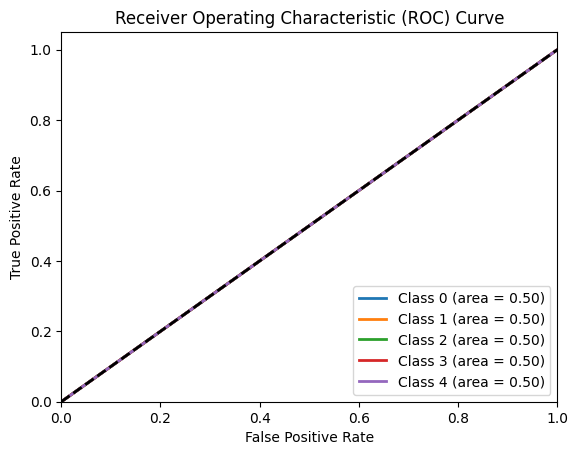

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on the test data
y_pred_prob = []
y_true = []

for images, labels in val:
    predictions = model_no_bn.predict(images)
    y_pred_prob.extend(predictions)
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Binarize the true labels for ROC calculation
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # Adjust classes to your number of classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], np.array(y_pred_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Lean CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Create a Sequential model
model_low_dropout = Sequential()

# Add convolutional layers with batch normalization and max pooling
model_low_dropout.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_low_dropout.add(BatchNormalization())
model_low_dropout.add(MaxPooling2D(pool_size=(2, 2)))

# Reduce dropout rate
model_low_dropout.add(Dropout(0.1))

# Flatten the output
model_low_dropout.add(Flatten())

# Add dense layers with batch normalization and reduced dropout
model_low_dropout.add(Dense(32, activation='relu'))
model_low_dropout.add(BatchNormalization())
model_low_dropout.add(Dropout(0.25))

# Output layer for multi-class classification
model_low_dropout.add(Dense(5, activation='softmax'))

# Compile the model
model_low_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_low_dropout.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 258064)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     8,258,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,258,885 (31.51 MB)

 Trainable params: 8,258,789 (31.50 MB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model_low_dropout.fit(train, epochs=75, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3740 - loss: 1.6237 - val_accuracy: 0.1875 - val_loss: 21.8457
Epoch 2/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6594 - loss: 0.9979 - val_accuracy: 0.1042 - val_loss: 17.5705
Epoch 3/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6865 - loss: 0.7650 - val_accuracy: 0.0833 - val_loss: 13.8531
Epoch 4/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7563 - loss: 0.7017 - val_accuracy: 0.0833 - val_loss: 10.1403
Epoch 5/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7844 - loss: 0.5996 - val_accuracy: 0.1146 - val_loss: 7.6700
Epoch 6/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7646 - loss: 0.6974 - val_accuracy: 0.1042 - val_loss: 6.1950
Epoch 7/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9167 - loss: 0.4762 - val_accuracy: 0.1250 - val_loss: 5.2066
Epoch 8/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8135 - loss: 0.5459 - val_accuracy: 0.0833 - val_loss: 4.7297
Epoch 9/75


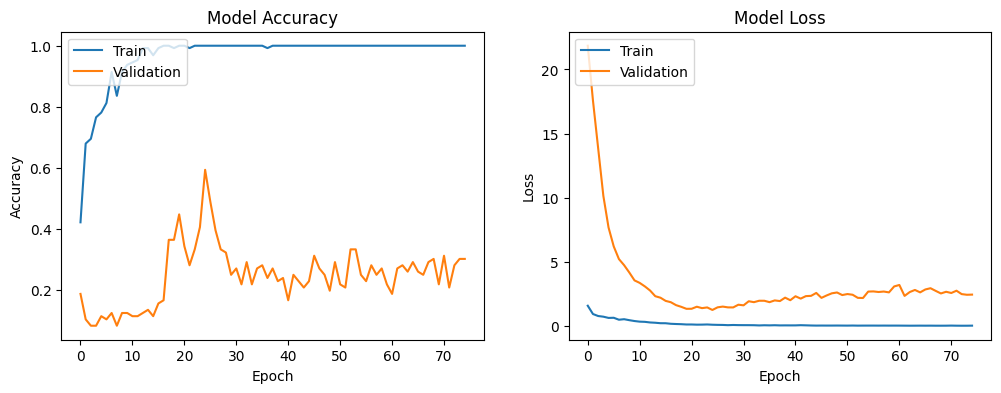

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


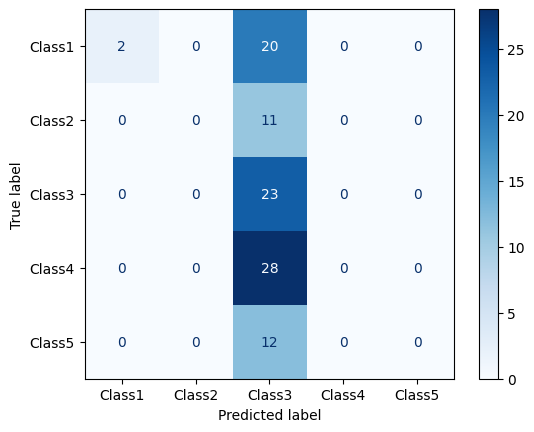

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test data
y_pred = []
y_true = []

for images, labels in val:
    predictions = model_low_dropout.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Class1', 'Class2', 'Class3', 'Class4', 'Class5'])  # Replace with your class labels
cmd.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test data
y_pred = []
y_true = []

for images, labels in train:
    predictions = model_low_dropout.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Class1', 'Class2', 'Class3', 'Class4', 'Class5'])  # Replace with your class labels
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
              precision    recall  f1-score   support

      Class1       0.00      0.00      0.00        21
      Class2       0.00      0.00      0.00        19
      Class3       0.25      1.00      0.40        32
      Class4       0.00      0.00      0.00        37
      Class5       0.00      0.00      0.00        19

    accuracy                           0.25       128
   macro avg       0.05      0.20      0.08       128
weighted avg       0.06      0.25      0.10       128



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


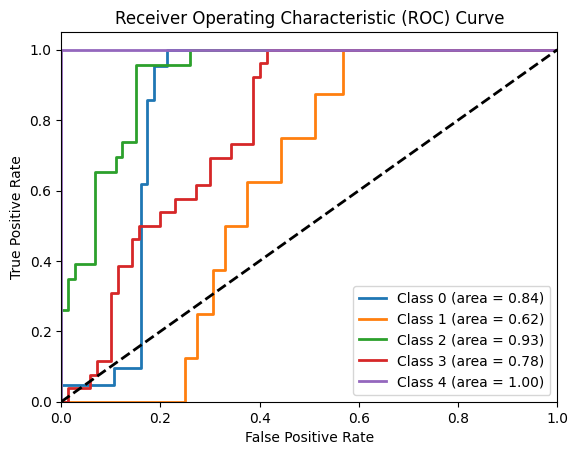

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test' is already defined and preprocessed as in the previous steps
# Predict probabilities on the test data
y_pred_prob = []
y_true = []

for images, labels in val:
    predictions = model_low_dropout.predict(images)
    y_pred_prob.extend(predictions)
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Binarize the true labels for ROC calculation
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # Adjust classes to your number of classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], np.array(y_pred_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Deep CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Create a Sequential model
model_deeper = Sequential()

# Add more convolutional layers with batch normalization and max pooling
model_deeper.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_deeper.add(BatchNormalization())
model_deeper.add(MaxPooling2D(pool_size=(2, 2)))
model_deeper.add(Conv2D(32, (3, 3), activation='relu'))
model_deeper.add(BatchNormalization())
model_deeper.add(MaxPooling2D(pool_size=(2, 2)))

# Add dropout
model_deeper.add(Dropout(0.25))

# Flatten the output
model_deeper.add(Flatten())

# Add dense layers with batch normalization and dropout
model_deeper.add(Dense(64, activation='relu'))
model_deeper.add(BatchNormalization())
model_deeper.add(Dropout(0.5))

# Output layer for multi-class classification
model_deeper.add(Dense(5, activation='softmax'))

# Compile the model
model_deeper.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_deeper.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 254, 254, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 125, 125, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     7,872,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,878,437 (30.05 MB)

 Trainable params: 7,878,213 (30.05 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model_deeper.fit(train, epochs=70, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4531 - loss: 1.1771 - val_accuracy: 0.1875 - val_loss: 3.3923
Epoch 2/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6406 - loss: 0.8925 - val_accuracy: 0.2083 - val_loss: 2.6593
Epoch 3/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7510 - loss: 0.5945 - val_accuracy: 0.1667 - val_loss: 2.3077
Epoch 4/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8438 - loss: 0.4980 - val_accuracy: 0.1979 - val_loss: 1.9012
Epoch 5/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7917 - loss: 0.5252 - val_accuracy: 0.4688 - val_loss: 1.8592
Epoch 6/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8531 - loss: 0.4155 - val_accuracy: 0.3125 - val_loss: 1.7920
Epoch 7/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8823 - loss: 0.3483 - val_accuracy: 0.1771 - val_loss: 1.8707
Epoch 8/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8979 - loss: 0.3394 - val_accuracy: 0.2396 - val_loss: 1.7827
Epoch 9/70

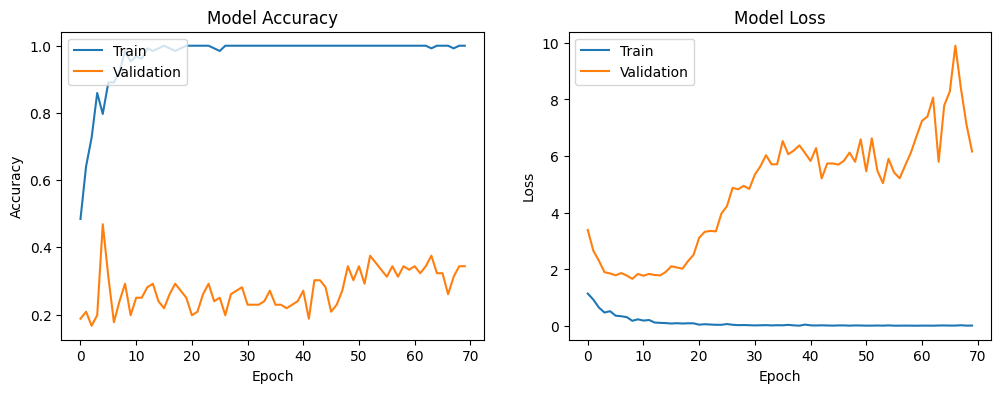

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


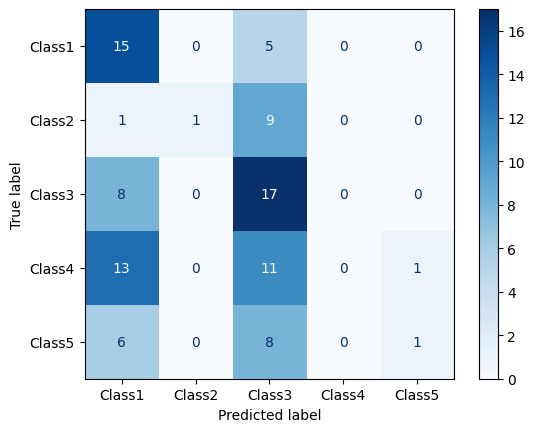

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test data
y_pred = []
y_true = []

for images, labels in val:
    predictions = model_deeper.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Class1', 'Class2', 'Class3', 'Class4', 'Class5'])  # Replace with your class labels
cmd.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test data
y_pred = []
y_true = []

for images, labels in train:
    predictions = model_deeper.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Class1', 'Class2', 'Class3', 'Class4', 'Class5'])  # Replace with your class labels
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
              precision    recall  f1-score   support

      Class1       0.23      0.80      0.35        15
      Class2       0.00      0.00      0.00        13
      Class3       0.39      0.76      0.51        38
      Class4       0.00      0.00      0.00        41
      Class5       0.00      0.00      0.00        21

    accuracy                           0.32       128
   macro avg       0.12      0.31      0.17       128
weighted avg       0.14      0.32      0.19       128



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


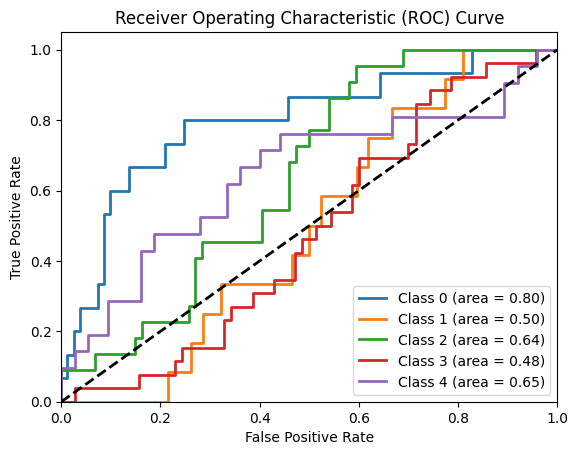

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test' is already defined and preprocessed as in the previous steps
# Predict probabilities on the test data
y_pred_prob = []
y_true = []

for images, labels in val:
    predictions = model_deeper.predict(images)
    y_pred_prob.extend(predictions)
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Binarize the true labels for ROC calculation
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # Adjust classes to your number of classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], np.array(y_pred_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


SGCNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming 256x256 input images
input_shape = (256, 256, 3)

# Segmentation model
def create_segmentation_model():
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool1)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up1)

    segmentation_model = Model(inputs, decoded, name='segmentation_model')
    return segmentation_model

# Classification model
def create_classification_model():
    inputs = Input(input_shape)

    # CNN layers
    conv1 = Conv2D(16, (3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    flatten = Flatten()(pool3)

    # Dense layers
    dense1 = Dense(256, activation='relu')(flatten)
    output = Dense(5, activation='softmax')(dense1)  # For multi-class classification with 5 classes

    classification_model = Model(inputs, output, name='classification_model')
    return classification_model

# Combined model
def create_hybrid_model():
    input_tensor = Input(input_shape)

    # Segmentation model
    segmentation_model = create_segmentation_model()
    segmentation_output = segmentation_model(input_tensor)

    # Classification model
    classification_model = create_classification_model()
    classification_output = classification_model(segmentation_output)

    hybrid_model = Model(inputs=input_tensor, outputs=classification_output, name='hybrid_model')
    return hybrid_model

# Compile the hybrid model
hybrid_model = create_hybrid_model()
hybrid_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the hybrid model architecture
hybrid_model.summary()


Model: "hybrid_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ segmentation_model (Functional) │ (None, 256, 256, 3)    │         1,763 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_model            │ (None, 5)              │    14,770,725 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,772,488 (56.35 MB)

 Trainable params: 14,772,488 (56.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = hybrid_model.fit(train, epochs=70, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.2125 - loss: 2.5804 - val_accuracy: 0.2812 - val_loss: 1.6182
Epoch 2/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.2750 - loss: 1.6451 - val_accuracy: 0.3333 - val_loss: 1.5688
Epoch 3/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.2594 - loss: 1.5868 - val_accuracy: 0.3021 - val_loss: 1.5630
Epoch 4/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.2688 - loss: 1.5470 - val_accuracy: 0.2292 - val_loss: 1.6540
Epoch 5/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.2156 - loss: 1.6093 - val_accuracy: 0.1979 - val_loss: 1.6046
Epoch 6/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.2781 - loss: 1.5699 - val_accuracy: 0.2292 - val_loss: 1.5850
Epoch 7/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.3302 - loss: 1.5339 - val_accuracy: 0.2708 - val_loss: 1.5384
Epoch 8/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.2604 - loss: 1.5443 - val_accuracy: 0.2708 - val_loss: 1.5201
Epoch 9/

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = hybrid_model.fit(train, epochs=2, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.9760 - loss: 0.0670 - val_accuracy: 0.9896 - val_loss: 0.0728
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.9937 - loss: 0.0505 - val_accuracy: 0.9896 - val_loss: 0.0495


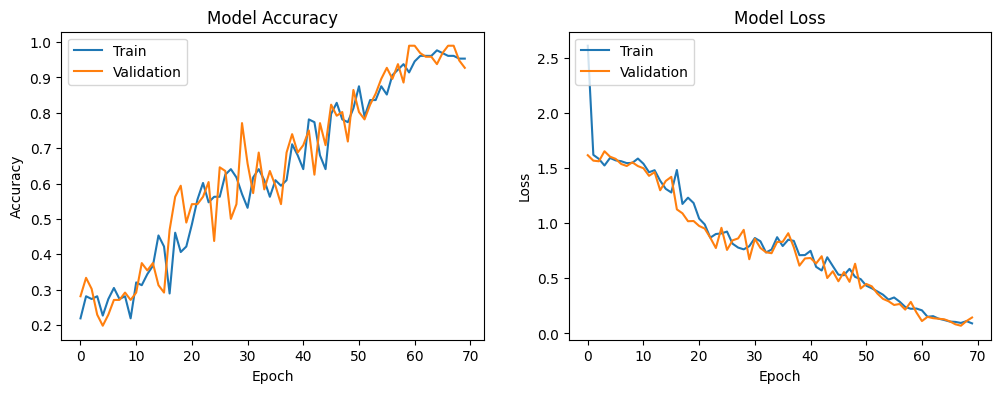

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


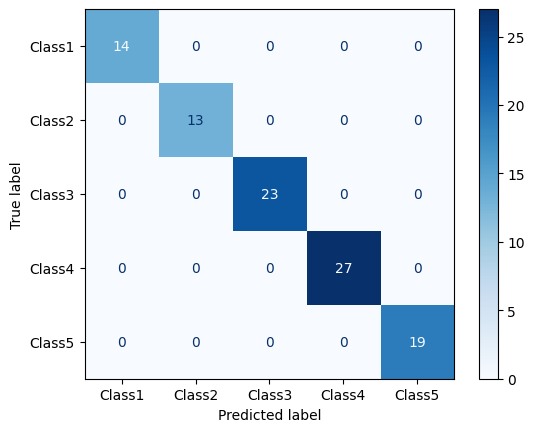

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test data
y_pred = []
y_true = []

for images, labels in val:
    predictions = hybrid_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Class1', 'Class2', 'Class3', 'Class4', 'Class5'])  # Replace with your class labels
cmd.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test data
y_pred = []
y_true = []

for images, labels in val:
    predictions = hybrid_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Class1', 'Class2', 'Class3', 'Class4', 'Class5'])  # Replace with your class labels
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
              precision    recall  f1-score   support

      Class1       1.00      1.00      1.00        22
      Class2       1.00      1.00      1.00         7
      Class3       1.00      1.00      1.00        17
      Class4       1.00      1.00      1.00        31
      Class5       1.00      1.00      1.00        19

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


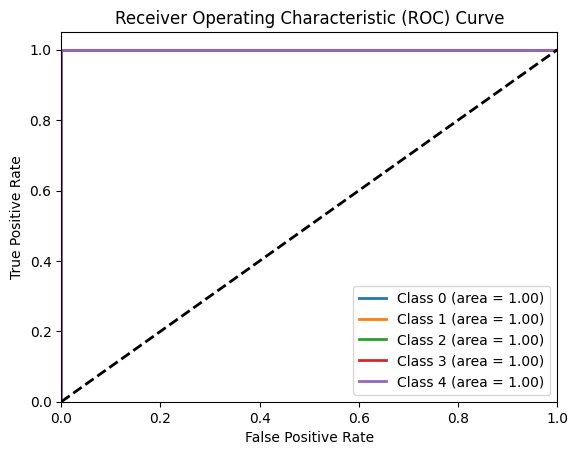

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test' is already defined and preprocessed as in the previous steps
# Predict probabilities on the test data
y_pred_prob = []
y_true = []

for images, labels in val:
    predictions = hybrid_model.predict(images)
    y_pred_prob.extend(predictions)
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Binarize the true labels for ROC calculation
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # Adjust classes to your number of classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], np.array(y_pred_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
